PART THREE: Study into Data Leakage

Version 1.0

This notebook reads in the given data and investigates possible data leakage and exploit this to get better score in predicting the future sales.

# Final project: predict future sales
## PART THREE : Study into Data Leakage
Started on `30 November 2017`

Author: `Rhodium Beng`

## Introduction

### This is the final project for the course on "Advanced Machine Learning: How to win a data science competition".
This final project is a competition that require the course participants to work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

### The Task:
The task is to predict the total sales for every item in every shop in the next month.

### Competition Evaluation:
Submissions are evaluated using root mean squared error (RMSE). 

### Project Advice:
True target values are clipped into [0,20] range.

In [1]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from math import sqrt

## Load data

In [2]:
sales = pd.read_csv('data/sales_train.csv')
items = pd.read_csv('data/items.csv')
item_categories = pd.read_csv('data/item_categories.csv')
# shops = pd.read_csv('data/shops.csv')
shops = pd.read_csv('shops_loc.csv')
test = pd.read_csv('data/test.csv')

### Some key observations from Part One: EDA.
* In the `test` dataset, there are only `42` unique shops and `5,100` unique items. 
* And some `17,070` items in the sales data are not in the test data.
* The question is: Are the information associated with the shops and items that are in the training data but not present in the test data relevant to the task of predicting the list of items in the test data?

### This looks like a data leakage where it is clear from the test data to only predict for certain shops, instead of for all shops. The shops should be quite independent of each other, and therefore those training data for shops that are not in the test dataset would in effect be irrelevant and can be removed.

## Let's remove all the 'irrelevant' training data from the `sales` dataset.

In [3]:
test_shops = test['shop_id'].unique()

In [4]:
relevant_sales = sales[np.isin(sales['shop_id'],test_shops)]

In [5]:
relevant_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
len(relevant_sales)

2413246

Almost half a million sales transactions are deemed irrelevant for predicting Nov 2015 sales.

## Aggregate data

Similar to Part One, we will need to aggregate the data to monthly level since the task is to predict monthly sales.

We will also add the test data into this grid. The `date_block_num` for the test data shall be `34`.

In [7]:
# Create grid with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in relevant_sales['date_block_num'].unique():
    cur_shops = relevant_sales[relevant_sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = relevant_sales[relevant_sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Add the shops/items from the test data and create date_block_num 34
block_num = 34
cur_shops = test['shop_id'].unique()
cur_items = test['item_id'].unique()
grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
    
# Turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns=index_cols, dtype=np.int32)

In [8]:
len(grid)

8812244

In [9]:
# The size of the grid should be the same as the dot product of shop_counts & item_counts
shop_counts = relevant_sales.groupby('date_block_num')['shop_id'].nunique()
item_counts = relevant_sales.groupby('date_block_num')['item_id'].nunique()
test_shops = test['shop_id'].nunique()
test_items = test['item_id'].nunique()
print(shop_counts.dot(item_counts) + test_shops * test_items)

8812244


In [10]:
# Get aggregated values for (shop_id, item_id, month)
gb = relevant_sales.groupby(index_cols, as_index=False)['item_cnt_day'].agg('sum')
# Rename column
gb = gb.rename(columns={'item_cnt_day':'target'})
# Join aggregated data to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

In [11]:
all_data.head()

,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


#### After the monthly aggregated dataframe has been generated, this part is to clip the true target values to the range of `[0,20]`. This would make a big difference in model fitting later on, as there are a few very large outliers as shown below. 

In [12]:
all_data['target'].describe()

count    8.812244e+06
mean     3.393472e-01
std      3.488570e+00
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.253000e+03
Name: target, dtype: float64

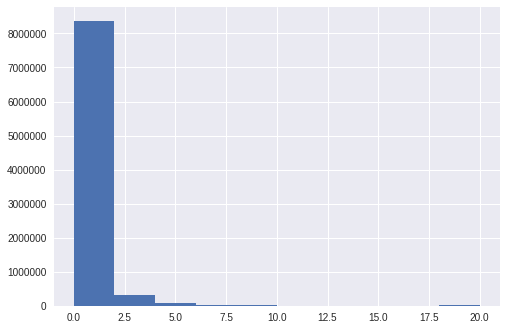

In [13]:
all_data['target'] = np.clip(all_data['target'], 0, 20)
sns.set()
plt.hist(all_data['target'])
plt.show()

## Feature Engineering: creating feature matrix
#### Typically, for time series, we can create features from date time, lagged features and others.

Let's create squared target to see if it improves the perf.

In [14]:
# all_data['sq_target'] = np.square(all_data['target'])

Let's create the target aggregate pairs, i.e. `target_shop` and `target_item`, aggregated by month.

In effect, the summing of target by shop and by item are "mean encodings". We can generate good features by create lagged values of these features too, similar to what we will do for `target`.

In [15]:
# Same as above in aggregating data, get aggregated values for (shop_id, month)
gb = relevant_sales.groupby(['shop_id', 'date_block_num'], as_index=False)['item_cnt_day'].agg('sum')
# Rename column
gb = gb.rename(columns={'item_cnt_day':'target_shop'})
# Join aggregated data to the grid
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

In [16]:
# Same as above, get aggregated values for (item_id, month)
gb = relevant_sales.groupby(['item_id', 'date_block_num'], as_index=False)['item_cnt_day'].agg('sum')
# Rename column
gb = gb.rename(columns={'item_cnt_day':'target_item'})
# Join aggregated data to the grid
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

In [57]:
# Add mean encoding of loc:
# adding loc to relevant sales:
relevant_sales
relevant_sales = relevant_sales.merge(shops[['shop_id', 'loc']], on='shop_id', how='left')
all_data.head()
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

encoded = encoder.fit_transform(all_data['loc'])
relevant_sales['loc'] = pd.Series(encoded)
# need to mean encoding the loc?
# Same as above, get aggregated values for (item_id, month)
gb_loc = relevant_sales.groupby(['loc', 'date_block_num'], as_index=False)['item_cnt_day'].agg('sum')
# Rename column
gb_loc = gb_loc.rename(columns={'item_cnt_day':'target_loc'})
# Join aggregated data to the grid
all_data = pd.merge(all_data, gb_loc, how='left', on=['loc', 'date_block_num']).fillna(0)

In [62]:
np.all(all_data.iloc[:, -1].values) == 0 # revoir mean encoding of locations!!

True

In [18]:
# all_data = all_data.merge(shops[['shop_id', 'loc']], on='shop_id', how='left')
# all_data.head()
# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

# encoded = encoder.fit_transform(all_data['loc'])
# all_data['loc'] = pd.Series(encoded)
# all_data['loc'].apply(lambda x: pd.factorize(x))

Next, let's create the lagged values as features just like in Part One. We will use the more recent values to predict the next values. Let's use lag window from `[1,2,3,4,5,6,12]` months ago. The 12 months ago shift should address the seasonal (yearly) component we observed in the plots during EDA.

In [19]:
# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols))

shift_range = [1, 2, 3, 4, 5, 6, 12]

for month_shift in shift_range:
    train_shift = all_data[index_cols + cols_to_rename].copy()
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)
    all_data = pd.merge(all_data, train_shift, how='left', on=index_cols).fillna(0)

del train_shift

In [20]:
# Since we have lagged the values by 12 months, we will not be able to use the older data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12]

In [21]:
# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]]
print(fit_cols)

['target_lag_1', 'target_item_lag_1', 'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3', 'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4', 'target_lag_5', 'target_item_lag_5', 'target_shop_lag_5', 'target_lag_6', 'target_item_lag_6', 'target_shop_lag_6', 'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12']


Following ARIMA general models let's introduce first order difference between lags.

In [22]:
all_data['target_diff_lag1-2'] = all_data['target_lag_1'] - all_data['target_lag_2']
all_data['target_diff_lag1-2'] = all_data['target_diff_lag1-2'].fillna(0)
# # seasonal differencing
# all_data['target_diff_lag11'] = all_data['target_lag_1'] - all_data['target_lag_12']
# all_data['target_diff_lag11'] = all_data['target_diff_lag11'].fillna(0)

In [23]:
# List of columns to drop at model fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num']
print(to_drop_cols)

['target_diff_lag1-2', 'target_shop', 'target_item', 'target', 'date_block_num']


#### Similarly, we add another feature, which is the category for each item, to the feature matrix.

In [24]:
# Create the mapping for item to item_category
item_category_mapping = items[['item_id', 'item_category_id']].drop_duplicates()
# Map and create new feature column 'item_category_id'
all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')

#### At this juncture, we've created a feature matrix, stored in the dataframe `all_data`. Let's take a look:

In [25]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,target_diff_lag1-2,item_category_id
0,55,492,12,20.0,1150.0,123.0,20.0,92.0,1383.0,20.0,...,71.0,719.0,20.0,60.0,795.0,0.0,0.0,0.0,0.0,76
1,55,490,12,1.0,1150.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,795.0,0.0,0.0,0.0,-1.0,78
2,55,488,12,1.0,1150.0,1.0,1.0,1.0,1383.0,1.0,...,1.0,719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78
3,55,446,12,1.0,1150.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44
4,55,132,12,1.0,1150.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44


We add the location extracted from the shop names.

In [27]:
len(all_data)

5459310

In [28]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,...,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,target_diff_lag1-2,item_category_id,loc
0,55,492,12,20.0,1150.0,123.0,20.0,92.0,1383.0,20.0,...,719.0,20.0,60.0,795.0,0.0,0.0,0.0,0.0,76,24
1,55,490,12,1.0,1150.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,795.0,0.0,0.0,0.0,-1.0,78,24
2,55,488,12,1.0,1150.0,1.0,1.0,1.0,1383.0,1.0,...,719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,78,24
3,55,446,12,1.0,1150.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,24
4,55,132,12,1.0,1150.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,24


## We will use the relevant dataset to train the two single models and predict the Nov 2015 sales forecast.
* Light GBM
* Linear Regression

In [29]:
seed = 7 # random seed for reproducibility

### Training/validation split
Here we'll use the holdout scheme to split the data into training and test data. We will treat the last month data, i.e. Nov 2015 as the test set, and train the model using the rest as the training data.

In [30]:
# Save 'date_block_num', as we can't use them as features, but will need them to split the data into parts
dates = all_data['date_block_num']
last_block = dates.max()
val_block = last_block - 1
print('Test `date_block_num` is %d' %last_block)

Test `date_block_num` is 34


Before outputting predictions for Nov 2015, let's validate and see the validation error for Oct 2015.

In [31]:
X_train = all_data.loc[dates < val_block].drop(to_drop_cols, axis=1)
y_train = all_data.loc[dates < val_block, 'target'].values

X_val = all_data.loc[dates == val_block].drop(to_drop_cols, axis=1)
y_val = all_data.loc[dates == val_block, 'target'].values

In [32]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.02, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 300)
pred_lgb = model.predict(X_val)

In [33]:
error = np.sqrt(mean_squared_error(y_val, pred_lgb))
print('Validation error for lgb: %f' % error)
# basic features and model validation error:
# Validation error for lgb: 0.823495
# lr = 0.02, n_iter = 250
# Validation error for lgb: 0.820920
# lr = 0.02, n_iter = 300
# Validation error for lgb: 0.820037
# lr = 0.01, n_iter = 600
# Validation error for lgb: 0.822748
# lr = 0.01, n_iter = 700
# Validation error for lgb: 0.822343
# lr = 0.02, n_iter = 300 and squared_target (same with 1st order difference on AR terms)
# Validation error for lgb: 0.820037
# lr = 0.02, n_iter = 300 and squared_target
# Validation error for lgb: 0.819597

Validation error for lgb: 0.820598


#### For model fitting, we will only use lagged values for `[1 to 6, 12]` months ago & `item_category`. 

In [34]:
dates_train = dates[dates < last_block]
dates_test = dates[dates == last_block]

X_train = all_data.loc[dates < last_block].drop(to_drop_cols, axis=1)
y_train = all_data.loc[dates < last_block, 'target'].values

X_test = all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
y_test = all_data.loc[dates == last_block, 'target'].values

Let's look at X and y, both train and test

In [35]:
X_train.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,loc
0,55,492,20.0,92.0,1383.0,20.0,128.0,1228.0,20.0,70.0,...,71.0,719.0,20.0,60.0,795.0,0.0,0.0,0.0,76,24
1,55,490,0.0,0.0,0.0,1.0,1.0,1228.0,1.0,1.0,...,0.0,0.0,1.0,1.0,795.0,0.0,0.0,0.0,78,24
2,55,488,1.0,1.0,1383.0,1.0,1.0,1228.0,1.0,1.0,...,1.0,719.0,0.0,0.0,0.0,0.0,0.0,0.0,78,24
3,55,446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,24
4,55,132,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44,24


In [36]:
len(X_train)

5245110

In [37]:
y_train

array([ 20.,   1.,   1., ...,   0.,   0.,   0.])

In [38]:
X_test.head()

,shop_id,item_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,...,target_item_lag_5,target_shop_lag_5,target_lag_6,target_item_lag_6,target_shop_lag_6,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id,loc
5245110,5,5037,0.0,25.0,1052.0,1.0,110.0,1092.0,3.0,117.0,...,95.0,954.0,1.0,82.0,1012.0,1.0,53.0,1445.0,19,3
5245111,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,3
5245112,5,5233,1.0,42.0,1052.0,3.0,80.0,1092.0,1.0,149.0,...,108.0,954.0,3.0,67.0,1012.0,0.0,0.0,0.0,19,3
5245113,5,5232,0.0,28.0,1052.0,0.0,48.0,1092.0,1.0,64.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23,3
5245114,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,3


In [39]:
len(X_test)

214200

In [40]:
y_test

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### Light GBM model
Let's run a light gbm on the numeric columns and get predictions for Nov 2015.

In [41]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.02, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 300)
pred_lgb = model.predict(X_test)
pred_lgb

array([ 0.51241947,  0.25463771,  0.96008796, ...,  0.02550761,
        0.02125699,  0.02125699])

Took 2 minutes to run.

### Linear regression model
Let's run a linear regression on the numeric columns and get predictions for Nov 2015. We will need to pre-process the features, i.e. normalize them.

In [42]:
# norm_df = all_data.loc[dates <= last_block].drop(to_drop_cols, axis=1)

In [43]:
# norm_df.head()

In [44]:
# linear_fit_cols = fit_cols + ['item_category_id']

In [45]:
# scaler = preprocessing.StandardScaler()
# norm_df[linear_fit_cols] = scaler.fit_transform(norm_df[linear_fit_cols])

In [46]:
# X_lin_train = norm_df.loc[dates < last_block]
# y_lin_train = all_data.loc[dates < last_block, 'target'].values

# X_lin_test = norm_df.loc[dates == last_block]
# y_lin_test = all_data.loc[dates == last_block, 'target'].values

Let's look at `X_lin` and `y_lin`, both train and test.

In [47]:
# X_lin_train.head()

In [48]:
# len(X_train)

In [49]:
# y_lin_train

In [50]:
# X_lin_test.head()

In [51]:
# len(X_lin_test)

In [52]:
# y_lin_test

In [53]:
# lr = LinearRegression()
# lr.fit(X_lin_train.values, y_lin_train)
# pred_lr = lr.predict(X_lin_test.values)
# pred_lr

## Subtask #3
#### Let do some leaderboard probing again and see what the results might be if we submit the predictions from the single models, i.e. Light GBM and Linear Regression, for the Nov 2015 sales forecast. However, this time we exploited the data leakage.

### Create and submit the Light GBM model predictions for Nov 2015.

In [54]:
pred_Nov15 = X_test.drop(linear_fit_cols, axis=1)
pred_Nov15['item_cnt_month'] = pred_lgb
pred_Nov15.head()

NameError: name 'linear_fit_cols' is not defined

In [ ]:
fit_cols

In [ ]:
pred_Nov15 = X_test.drop(fit_cols + ['item_category_id'], axis = 1)
pred_Nov15['item_cnt_month'] = pred_lgb #.clip(0,20)
pred_Nov15.head()

In [ ]:
result = pd.merge(test, pred_Nov15, how='left', on=['shop_id', 'item_id']).fillna(0)
result.head()

In [ ]:
# Generate submission file in csv format
submission = result.drop(['shop_id', 'item_id'], axis=1)
submission.to_csv('submission_leak_lgb.csv', index=False)

#### Exploiting the data leakage, the Public Leaderboard returned a score of `0.93708` which is a tiny improvement of `0.93860`.

### Create and submit the linear regression model predictions for Nov 2015.

In [ ]:
pred_Nov15 = X_test.drop(linear_fit_cols, axis=1)
pred_Nov15['item_cnt_month'] = pred_lr
pred_Nov15.head()

In [ ]:
result = pd.merge(test, pred_Nov15, how='left', on=['shop_id', 'item_id']).fillna(0)
result.head()

In [ ]:
# Generate submission file in csv format
submission = result.drop(['shop_id', 'item_id'], axis=1)
submission.to_csv('submission_leak_lr.csv', index=False)

#### Exploiting the data leakage, the Public Leaderboard returned a score of `1.02240`, just a shade better than `1.02245`.

### This appears to be the data leakage to me in the test data. While there is consistent slight improvement among the models, the improvement is tiny. But this can translate to a few position jumps in the Leaderboard eventually, perhaps. 